## Generate R0 samples

In [1]:
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import os
import argparse
from diffusers import StableDiffusionPipeline, StableDiffusionXLPipeline, UNet2DConditionModel, StableDiffusion3Pipeline
from transformers import CLIPTextModel
from utils.misc import *
from utils.clip_eval import CLIPEvaluator
import pandas as pd
import hpsv2


/home/xulu2/anaconda3/envs/GAL/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def load_weights(backbone, pipe, checkpoint_dir):
    if backbone == "SD":
        unet = UNet2DConditionModel.from_pretrained(os.path.join(checkpoint_dir, 'unet'), torch_dtype=torch.float16).to(pipe.device)
        pipe.unet = unet
        if os.path.exists(os.path.join(checkpoint_dir, 'text_encoder')):
            text_encoder = CLIPTextModel.from_pretrained(os.path.join(checkpoint_dir, 'text_encoder')).to(pipe.device)
            pipe.text_encoer = text_encoder
    elif backbone == "SD3":
        pipe.load_lora_weights(checkpoint_dir, weight_name='pytorch_lora_weights.safetensors', torch_dtype=torch.float16)
    return pipe

def init_generative_model(backbone, pretrained_model_name_or_path, device):
    # Load the model
    if backbone == "SD" or backbone == "StableDiffusion":
        pipe = StableDiffusionPipeline.from_pretrained(pretrained_model_name_or_path, torch_dtype=torch.float16).to(device)
    elif backbone == "SDXL":
        pipe = StableDiffusionXLPipeline.from_pretrained(pretrained_model_name_or_path).to(device)
    elif backbone == "SD3":
        pipe = StableDiffusion3Pipeline.from_pretrained(pretrained_model_name_or_path, torch_dtype=torch.float16).to(device)
    else:
        raise ValueError("Invalid backbone")
    return pipe

def generate_lexica_images(backbone, pipe, output_dir):
    # Get benchmark prompts (<style> = all, anime, concept-art, paintings, photo)
    df = pd.read_csv('/home/xulu2/Text2Image/data/lexica/metadata_loop_30k-step30-num300-portion25-weight.csv')
    #prompts = df['Prompt'].values
    df = df[df['round'] == 0]
    # reset index
    df.reset_index(drop=True, inplace=True)
    for idx in range(len(df)):
        prompt = df.loc[idx, 'prompt']
        path = df.loc[idx, 'path']
        img_path = os.path.join(output_dir, path)
        # try:
        #     im = preprocess_val(Image.open(img_path))
        # except:
        if os.path.exists(img_path):
            continue
        if backbone == "SD":
            image = pipe(prompt, guidance_scale=7, num_images_per_prompt=1, num_inference_steps=50).images[0]
        elif backbone == "SD3":
            image = pipe(prompt, guidance_scale=7, num_images_per_prompt=1, num_inference_steps=28).images[0]
        else:
            raise ValueError("Invalid backbone")
        # TextToImageModel is the model you want to evaluate
        check_mkdir(os.path.dirname(img_path))
        image.save(img_path)


def main():
    pipe = init_generative_model('SD', "runwayml/stable-diffusion-v1-5", 'cuda:0')
    # load finetuned model
    unet_id = "mhdang/dpo-sd1.5-text2image-v1"
    unet = UNet2DConditionModel.from_pretrained(unet_id, subfolder="unet", torch_dtype=torch.float16)
    pipe.unet = unet
    pipe = pipe.to('cuda:0')
    #print(f"Loading weights from {args.checkpoint_dir}")
    #pipe = load_weights(args.backbone, pipe, args.checkpoint_dir)
    #generate_hps_images(pipe, '/home/xulu2/Text2Image/samples/civitai')
    generate_lexica_images('SD', pipe, '/home/xulu2/Text2Image/data/lexica/by_DPO/R0')

main()

## Get the Good and Bad samples
#### 1. Calculate hps score and distribution distance;
#### 2. Calaulate the sample weights based on the distance;
#### 3. Find the topk pairs based on the scores;
#### 4. Visualize the pairs.

In [3]:
# cal hps_R0
df = pd.read_csv('/home/xulu2/Text2Image/data/lexica/metadata_loop_30k-step30-num300-portion25-weight.csv')
df = df[df['round'] == 0]
prompts = df['prompt'].values
image_paths = ['../data/lexica/by_DPO/R0/' + p for p in df.path.values]
results = hpsv2.score_pairs(image_paths, prompts, hps_version='v2.1', device='cuda:7')

df = pd.read_csv('/home/xulu2/Text2Image/data/lexica/metadata_loop_30k-step30-num300-portion25-weight.csv')
idx = df[df['round'] == 0].index
df.loc[idx, 'hps_R0'] = results

/home/xulu2/anaconda3/envs/GAL/lib/python3.10/site-packages/hpsv2/src/open_clip/factory.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoi

Processing the 0 th image...
Processing the 1000 th image...
Processing the 2000 th image...
Processing the 3000 th image...
Processing the 4000 th image...


In [4]:
# cal dis_R0
def get_latent_feat(img_path, vae, image_transforms):
    image = Image.open(img_path).convert('RGB')
    inputs = image_transforms(image).unsqueeze(0).to(vae.device)
    latent_feat = vae.encode(inputs.to(dtype=torch.float16)).latent_dist.sample()
    return latent_feat.detach().cpu().squeeze()

def cal_distribution_distance(feats, mean_feats):
    distance = np.linalg.norm(feats - mean_feats, axis=1)
    return distance

def process_distribution_dis(vae, img_paths):
    size = 512
    image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )
    dis_list = []
    mean_feats = np.load('mean.npy')
    for img_path in img_paths:
        latent_feat = get_latent_feat(img_path, vae, image_transforms)
        dis = cal_distribution_distance(latent_feat, mean_feats)
        dis_list.append(dis.mean())
    return dis_list

pipe = init_generative_model('SD', "runwayml/stable-diffusion-v1-5", 'cuda:0')
dis_list = process_distribution_dis(pipe.vae, image_paths)
df.loc[idx, 'dis_R0'] = dis_list


Loading pipeline components...:  29%|██▊       | 2/7 [00:00<00:01,  3.11it/s]/home/xulu2/anaconda3/envs/GAL/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  6.78it/s]


In [5]:
# cal the weight
idx = df[df['round'] == 0].index
weight_alpha=2
weight_beta=35
df.loc[idx, 'weight'] = np.clip(np.exp(-(df.loc[idx, 'dis_R0']-weight_beta)/weight_alpha), 0., 1.)
#df.loc[idx, 'weight_2'] = np.clip(np.exp(-(df.loc[idx, 'dis_R0_2']-weight_beta)/weight_alpha), 0., 1.)
df.to_csv('/home/xulu2/Text2Image/data/lexica/metadata_dpo_50k-step30-num300-portion25-weight.csv', index=False)

In [ ]:
def get_pos_and_neg_imgs(dataframe, 
                         output_dir='30k-step30-num300-portion25-weight', 
                         root_dir='/home/xulu2/Text2Image/data/lexica/by_SD_v14', 
                         weight_alpha=2, 
                         weight_beta=35,
                         topk=None):
    topk = len(dataframe) if topk is None else topk

    prompts = []
    pos_img = []
    neg_img = []
    pos_w = []
    neg_w = []

    hps_0 = dataframe['hps'].values
    hps_1 = dataframe['hps_2'].values
    dis_0 = dataframe['dis'].values
    dis_1 = dataframe['dis_2'].values
    weight_0 = dataframe['weight'].values
    weight_1 = dataframe['weight_2'].values
    paths = dataframe['path'].values
    captions = dataframe['prompt'].values
    rounds = dataframe['round'].values

    # threshold is the top 30% of hps_0 and hps_1
    hps_thred = np.percentile(hps_0, 70)
    dis_thred = 40

    hps_diff = hps_0 - hps_1
    indexs = np.argsort(np.abs(hps_diff))[::-1]
    print(hps_diff[indexs])
    for idx in indexs:
        if hps_diff[idx] > 0 and hps_0[idx] > hps_thred and dis_0[idx] < dis_thred:
            prompts.append(captions[idx])
            if rounds[idx] == 0:
                pos_img.append(os.path.join(root_dir, f"R{rounds[idx]}", paths[idx]))
                neg_img.append(os.path.join(root_dir, f"R{rounds[idx]}_2", paths[idx]))
                pos_w.append(np.clip(np.exp(-(dis_0[idx]-weight_beta)/weight_alpha), 0., 1.))
                neg_w.append(np.clip(np.exp(-(dis_1[idx]-weight_beta)/weight_alpha), 0., 1.))
            else:
                pos_img.append(os.path.join(root_dir, f"{output_dir.split('_')[-1]}/R{rounds[idx]}", paths[idx]))
                neg_img.append(os.path.join(root_dir, f"{output_dir.split('_')[-1]}/R{rounds[idx]}_2", paths[idx]))
                pos_w.append(weight_0[idx])
                neg_w.append(weight_1[idx])
        elif hps_diff[idx] < 0 and hps_1[idx] > hps_thred and dis_1[idx] < dis_thred:
            prompts.append(captions[idx])
            if rounds[idx] == 0:
                pos_img.append(os.path.join(root_dir, f"R{rounds[idx]}_2", paths[idx]))
                neg_img.append(os.path.join(root_dir, f"R{rounds[idx]}", paths[idx]))
                pos_w.append(np.clip(np.exp(-(dis_1[idx]-weight_beta)/weight_alpha), 0., 1.))
                neg_w.append(np.clip(np.exp(-(dis_0[idx]-weight_beta)/weight_alpha), 0., 1.))
            else:
                pos_img.append(os.path.join(root_dir, f"{output_dir.split('_')[-1]}/R{rounds[idx]}_2", paths[idx]))
                neg_img.append(os.path.join(root_dir, f"{output_dir.split('_')[-1]}/R{rounds[idx]}", paths[idx]))
                pos_w.append(weight_1[idx])
                neg_w.append(weight_0[idx])
    return prompts[:topk], pos_img[:topk], neg_img[:topk], pos_w[:topk], neg_w[:topk]


In [28]:
df = df[df['round'] == 0]
df.reset_index(drop=True, inplace=True)
df.rename(columns={'hps_R0': 'hps', 'dis_R0': 'dis', 'hps_R0_2': 'hps_2', 'dis_R0_2': 'dis_2'}, inplace=True)
prompts, pos_img, neg_img, pos_w, neg_w = get_pos_and_neg_imgs(df)

[-1.48280469e-01 -1.47843750e-01  1.46403320e-01 ...  2.07031250e-05
  1.05468750e-05 -9.76562500e-06]


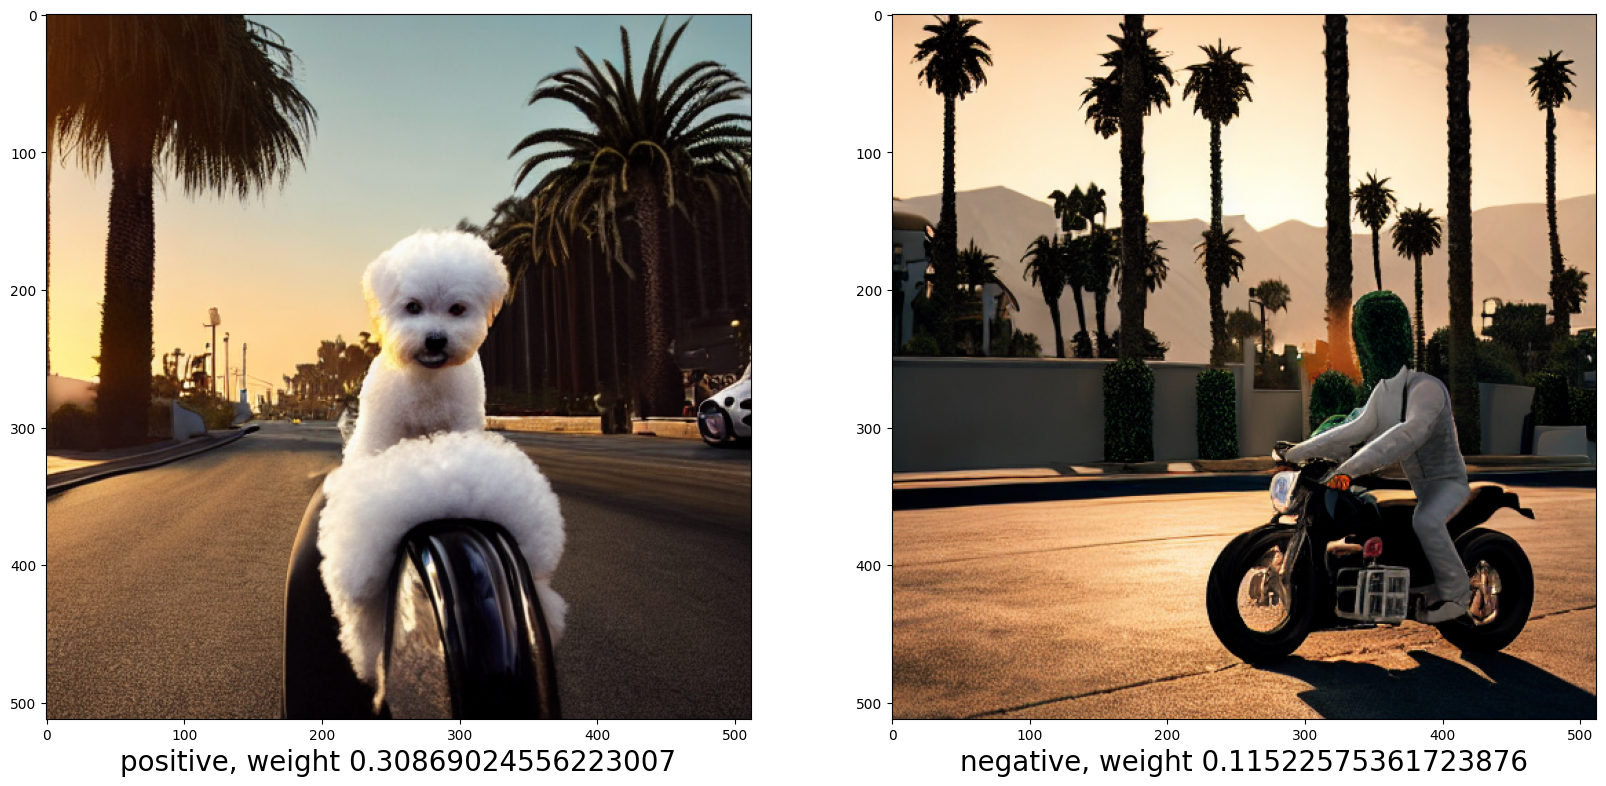

a photorealistic image of a white bichon frise puppy dog riding a black motorcycle in Hollywood at sundown. Palm trees in the background. Paws on handlebars. This 4K HD image is Trending on Artstation, featured on Behance, well-rendered, extra crisp, features intricate detail and the style of Unreal Engine.


In [113]:
# show some positive and negative images
show_idx = 299
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
#plt.title(prompts[show_idx], fontsize=20)
plt.subplot(1, 2, 1)
plt.xlabel(f'positive, weight {pos_w[show_idx]}', fontsize=20)
plt.imshow(np.array(Image.open(pos_img[show_idx])))

plt.subplot(1, 2, 2)
plt.imshow(np.array(Image.open(neg_img[show_idx])))
plt.xlabel(f'negative, weight {neg_w[show_idx]}', fontsize=20)
plt.show()
print(prompts[show_idx])

## Test the method, including HPS v2, Pickscore, CLIP score, ImageReward

In [1]:
import sys

import numpy as np
import pandas as pd
import torch
from utils.clip_eval import *
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import os
from utils import hps_eval
import hpsv2
import ImageReward as RM
from utils.aesthetic_scorer import AestheticScorer

/home/haoqian/anaconda3/envs/golden/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'hps_eval' from 'utils' (unknown location)

In [2]:
def calculate_clip_score(captions, sample_dir, device='cuda:0'):
    scores = []
    evaluator = CLIPEvaluator(device=device)
    for index, caption in captions.items():
        image_path = os.path.join(sample_dir, f"{index}.jpg")
        image = Image.open(image_path).convert('RGB')
        score = evaluator.txt_to_img_similarity(generated_images=image, text=caption).cpu().numpy()
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def evaluate(sample_dir, device):
    clip_score = calculate_clip_score(
        get_coco_1k_captions(),
        sample_dir,
        device=device
    )

    fid, details = calculate_fid(
        get_coco_fid_1k_stats(),
        sample_dir,
        device=device
    )

    df = pd.DataFrame({'sample_dir':sample_dir, 'fid':fid, 'clip':clip_score}, index=[0])
    return df

def evaluate_image_reward(img_paths, prompts, device):
    reward_model = RM.load("ImageReward-v1.0", device=device)
    scores = []
    for i in range(len(img_paths)):
        scores.append(reward_model.score(prompts[i], [img_paths[i]]))
    return scores

def evaluate_clip_text_align(img_paths, prompts, device):
    evaluator = CLIPEvaluator(device=device)
    scores = []
    for i in range(len(img_paths)):
        image = Image.open(img_paths[i]).convert('RGB')
        scores.append(evaluator.txt_to_img_similarity(generated_images=image, text=prompts[i]).cpu().numpy())
        if i % 1000 == 0:
            print(i)
    return scores

def evaluate_pick_score(img_paths, prompts, device):
    evaluator = PickEvaluator(device=device)
    scores = []
    for i in range(len(img_paths)):
        image = Image.open(img_paths[i]).convert('RGB')
        scores.append(evaluator.calc_probs(images=image, prompt=prompts[i]))
        if i % 1000 == 0:
            print(i)
    return scores

def evaluate_hps(img_paths, prompts):
    scores = hpsv2.score_pairs(img_paths, prompts, hps_version='v2.1')
    return scores


def aesthetic_score(img_paths, device):
    
    scorer = AestheticScorer(dtype=torch.float32).to(device)

    scores = []
    for i in range(len(img_paths)):
        image = Image.open(img_paths[i]).convert('RGB')
        image = torch.tensor(np.array(image) * 255).round().clamp(0, 255).to(torch.uint8)
        # tenssor to numpy
        scores.append(scorer(image).detach().cpu().numpy())
    return scores

def get_parti_prompt_and_paths(sample_dir):
    df = pd.read_csv('/home/xulu2/Text2Image/Prompt_Scorer/prompt_data/PartiPrompts.csv')
    prompts = df['Prompt'].values
    img_paths = [os.path.join(sample_dir, f"{i}.jpg") for i in range(len(df))]
    return img_paths, prompts

def get_hps_prompt_and_paths(sample_dir):
    prompt_list = []
    img_paths = []
    all_prompts = hpsv2.benchmark_prompts('all')
    for style, prompts in all_prompts.items():
        for idx, prompt in enumerate(prompts[:100]):
            img_path = os.path.join(sample_dir, style, f"{idx:05d}.jpg")
            prompt_list.append(prompt)
            img_paths.append(img_path)
    return img_paths, prompt_list

In [3]:
df = pd.read_csv('./results.csv')
#df = pd.DataFrame()
device = 'cuda:2'
for ckp in np.arange(1,7):
    sample_dir = f"/home/xulu2/Text2Image/samples/scaling/RSIDiff_DPO/R{ckp}/checkpoint-30/HPS"
    results = hpsv2.evaluate(sample_dir, hps_version="v2.1")
    img_paths, prompts = get_hps_prompt_and_paths(sample_dir)
    #results['hpsv2'] = np.mean(evaluate_hps(img_paths, prompts))
    results['pick_a_pic'] = np.mean(evaluate_pick_score(img_paths, prompts, device))
    results['image_reward'] = np.mean(evaluate_image_reward(img_paths, prompts, device))
    results['clip'] = np.mean(evaluate_clip_text_align(img_paths, prompts, device))
    results['aesthetic'] = np.mean(aesthetic_score(img_paths, device))
    results['sample_dir'] = sample_dir
    df = pd.concat([df, pd.DataFrame([results])], ignore_index=True)
df.to_csv('./results.csv', index=False)


INFO:root:Loaded ViT-H-14 model config.


Loading model ...
Loading model successfully!
missing image for prompt: A portrait painting of Priscilla from Claymore with intricate details and an eerie, realistic style, created by Artgerm, Greg Rutkowski, and Alphonse Mucha.
missing image for prompt: An atom bomb explosion in Heaven, depicted in the oil on canvas masterpiece by Thomas Cole, currently trending on ArtStation.
missing image for prompt: Katie McGrath is depicted as the princess of mars in a symmetrical art nouveau portrait by Gil Elvgren.
missing image for prompt: A pirate with a beer is illustrated in detailed digital painting.
missing image for prompt: A dilapidated shack hidden in a misty, overgrown Witchwood forest inhabited by evil fairies, depicted in a detailed, ink illustration by Greg Rutkowski.
missing image for prompt: A painting of a crystal mine featuring mechanical mining equipment.
missing image for prompt: A painting of an enhanced person by several artists, trending on ArtStation.
missing image for pro

INFO:timm.models.helpers:Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)


0
Loading model ...
Loading model successfully!
missing image for prompt: A portrait painting of Priscilla from Claymore with intricate details and an eerie, realistic style, created by Artgerm, Greg Rutkowski, and Alphonse Mucha.
missing image for prompt: An atom bomb explosion in Heaven, depicted in the oil on canvas masterpiece by Thomas Cole, currently trending on ArtStation.
missing image for prompt: Katie McGrath is depicted as the princess of mars in a symmetrical art nouveau portrait by Gil Elvgren.
missing image for prompt: A pirate with a beer is illustrated in detailed digital painting.
missing image for prompt: A dilapidated shack hidden in a misty, overgrown Witchwood forest inhabited by evil fairies, depicted in a detailed, ink illustration by Greg Rutkowski.
missing image for prompt: A painting of a crystal mine featuring mechanical mining equipment.
missing image for prompt: A painting of an enhanced person by several artists, trending on ArtStation.
missing image for p

INFO:timm.models.helpers:Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)


0
Loading model ...
Loading model successfully!
missing image for prompt: A portrait painting of Priscilla from Claymore with intricate details and an eerie, realistic style, created by Artgerm, Greg Rutkowski, and Alphonse Mucha.
missing image for prompt: An atom bomb explosion in Heaven, depicted in the oil on canvas masterpiece by Thomas Cole, currently trending on ArtStation.
missing image for prompt: Katie McGrath is depicted as the princess of mars in a symmetrical art nouveau portrait by Gil Elvgren.
missing image for prompt: A pirate with a beer is illustrated in detailed digital painting.
missing image for prompt: A dilapidated shack hidden in a misty, overgrown Witchwood forest inhabited by evil fairies, depicted in a detailed, ink illustration by Greg Rutkowski.
missing image for prompt: A painting of a crystal mine featuring mechanical mining equipment.
missing image for prompt: A painting of an enhanced person by several artists, trending on ArtStation.
missing image for p

INFO:timm.models.helpers:Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)


0
Loading model ...
Loading model successfully!
missing image for prompt: A portrait painting of Priscilla from Claymore with intricate details and an eerie, realistic style, created by Artgerm, Greg Rutkowski, and Alphonse Mucha.
missing image for prompt: An atom bomb explosion in Heaven, depicted in the oil on canvas masterpiece by Thomas Cole, currently trending on ArtStation.
missing image for prompt: Katie McGrath is depicted as the princess of mars in a symmetrical art nouveau portrait by Gil Elvgren.
missing image for prompt: A pirate with a beer is illustrated in detailed digital painting.
missing image for prompt: A dilapidated shack hidden in a misty, overgrown Witchwood forest inhabited by evil fairies, depicted in a detailed, ink illustration by Greg Rutkowski.
missing image for prompt: A painting of a crystal mine featuring mechanical mining equipment.
missing image for prompt: A painting of an enhanced person by several artists, trending on ArtStation.
missing image for p

INFO:timm.models.helpers:Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)


0
Loading model ...
Loading model successfully!
missing image for prompt: A portrait painting of Priscilla from Claymore with intricate details and an eerie, realistic style, created by Artgerm, Greg Rutkowski, and Alphonse Mucha.
missing image for prompt: An atom bomb explosion in Heaven, depicted in the oil on canvas masterpiece by Thomas Cole, currently trending on ArtStation.
missing image for prompt: Katie McGrath is depicted as the princess of mars in a symmetrical art nouveau portrait by Gil Elvgren.
missing image for prompt: A pirate with a beer is illustrated in detailed digital painting.
missing image for prompt: A dilapidated shack hidden in a misty, overgrown Witchwood forest inhabited by evil fairies, depicted in a detailed, ink illustration by Greg Rutkowski.
missing image for prompt: A painting of a crystal mine featuring mechanical mining equipment.
missing image for prompt: A painting of an enhanced person by several artists, trending on ArtStation.
missing image for p

INFO:timm.models.helpers:Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)


0
Loading model ...
Loading model successfully!
missing image for prompt: A portrait painting of Priscilla from Claymore with intricate details and an eerie, realistic style, created by Artgerm, Greg Rutkowski, and Alphonse Mucha.
missing image for prompt: An atom bomb explosion in Heaven, depicted in the oil on canvas masterpiece by Thomas Cole, currently trending on ArtStation.
missing image for prompt: Katie McGrath is depicted as the princess of mars in a symmetrical art nouveau portrait by Gil Elvgren.
missing image for prompt: A pirate with a beer is illustrated in detailed digital painting.
missing image for prompt: A dilapidated shack hidden in a misty, overgrown Witchwood forest inhabited by evil fairies, depicted in a detailed, ink illustration by Greg Rutkowski.
missing image for prompt: A painting of a crystal mine featuring mechanical mining equipment.
missing image for prompt: A painting of an enhanced person by several artists, trending on ArtStation.
missing image for p

INFO:timm.models.helpers:Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)


0


In [4]:
# For PartiPrompts dataset
df = pd.read_csv('./results.csv')
device = 'cuda:0'
for ckp in np.arange(1,7):
    sample_dir = f"/home/xulu2/Text2Image/samples/scaling/RSIDiff_DPO/R{ckp}/checkpoint-30/parti"
    results = {}
    results['sample_dir'] = sample_dir
    img_paths, prompts = get_parti_prompt_and_paths(sample_dir)
    results['parti_hpsv2'] = np.mean(evaluate_hps(img_paths, prompts))
    results['parti_pick_a_pic'] = np.mean(evaluate_pick_score(img_paths, prompts, device))
    results['parti_image_reward'] = np.mean(evaluate_image_reward(img_paths, prompts, device))
    results['parti_clip'] = np.mean(evaluate_clip_text_align(img_paths, prompts, device))
    results['parti_aesthetic'] = np.mean(aesthetic_score(img_paths, device))
    df = pd.concat([df, pd.DataFrame([results])], ignore_index=True)
df.to_csv('./results.csv', index=False)

INFO:root:Loaded ViT-H-14 model config.
INFO:root:Loading pretrained ViT-H-14 weights (laion2B-s32B-b79K).


Processing the 0 th image...
Processing the 1000 th image...
0
1000
load checkpoint from /home/xulu2/.cache/ImageReward/ImageReward.pt
checkpoint loaded


INFO:timm.models.helpers:Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)


0
1000
Processing the 0 th image...
Processing the 1000 th image...
0
1000
load checkpoint from /home/xulu2/.cache/ImageReward/ImageReward.pt
checkpoint loaded


INFO:timm.models.helpers:Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)


0
1000
Processing the 0 th image...
Processing the 1000 th image...
0
1000
load checkpoint from /home/xulu2/.cache/ImageReward/ImageReward.pt
checkpoint loaded


INFO:timm.models.helpers:Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)


0
1000
Processing the 0 th image...
Processing the 1000 th image...
0
1000
load checkpoint from /home/xulu2/.cache/ImageReward/ImageReward.pt
checkpoint loaded


INFO:timm.models.helpers:Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)


0
1000
Processing the 0 th image...
Processing the 1000 th image...
0
1000
load checkpoint from /home/xulu2/.cache/ImageReward/ImageReward.pt
checkpoint loaded


INFO:timm.models.helpers:Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)


0
1000
Processing the 0 th image...
Processing the 1000 th image...
0
1000
load checkpoint from /home/xulu2/.cache/ImageReward/ImageReward.pt
checkpoint loaded


INFO:timm.models.helpers:Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)


0
1000
